# Case 1. Heart Disease Classification 
    Cognitive Systems for Health Technology Applications
    4.2.2019, Emil Rantanen ja Wille Tuovinen
    Metropolia University of Applied Sciences

This is the code made for the Case 1 exercise of the Cognitive Systems for Health Technology applications. Due to lack of experience in the subject, it is mainly based on the teachers drafty notes example. While me and Wille signed up to work as a team, we ended up making our own codes this time to get used to the environment. As such most of the time was spent around tinkering with the code and figuring out what different parts do.

The goals of this assignment were to get used to and improve our skills with python and its libraries such as pandas and keras. We also aimed to learn more about testing model architectures, solver optimizers and training settings and then using matplotlib's visualization tools to give results a nice graphical presentation. Finally, we practised giving the results a clear and easily readable documentation, which you are reading now.

Link to the drafty notes can be found here: https://github.com/sakluk/cognitive-systems-for-health-technology/blob/master/Week_2_Case_1_(drafty_notes).ipynb

In [2]:
import time
import warnings
import pandas as pd
import matplotlib.pyplot as plt
from pylab import *

from sklearn.utils import shuffle
from sklearn.preprocessing import normalize
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support

from keras.utils import to_categorical
from keras import models, layers
from keras.models import Sequential
from keras.layers import Dense, Activation

Using TensorFlow backend.


### Reading the file

In this first section the data file is read and we give the columns their proper names. Empty parts are filled with the median value of their respective column. The rows are then shuffled and we check that the data looks like what me might expect.

The file itself is a part of a heart disease directory. In the file used here the data is from Cleveland Clinic Foundation, with 14 different attributes used. As per the request of the authrs of the databases, the principal investigator responsible for the data collection in Cleveland was Robert Detrano.

In [3]:
#reading the file and applying proper names for the columns
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data'
df = pd.read_csv(url,header=None,index_col=None,sep=',',na_values='?')
df.columns = ['age','sex','cp','trestbps','chol','fbs','restecg','thalach',
                'exang','oldpeak','slope','ca','thal','num']

#fill missing data with respective column's median value, then shuffle the rows
df = df.fillna(df.median())
df = shuffle(df)

df.describe()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
count,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000
mean,54.438944,0.679868,3.158416,131.689769,246.693069,0.148515,0.990099,149.607261,0.326733,1.039604,1.600660,0.663366,4.722772,0.937294
std,9.038662,0.467299,0.960126,17.599748,51.776918,0.356198,0.994971,22.875003,0.469794,1.161075,0.616226,0.934375,1.938383,1.228536
min,29.000000,0.000000,1.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,1.000000,0.000000,3.000000,0.000000
25%,48.000000,0.000000,3.000000,120.000000,211.000000,0.000000,0.000000,133.500000,0.000000,0.000000,1.000000,0.000000,3.000000,0.000000
50%,56.000000,1.000000,3.000000,130.000000,241.000000,0.000000,1.000000,153.000000,0.000000,0.800000,2.000000,0.000000,3.000000,0.000000
75%,61.000000,1.000000,4.000000,140.000000,275.000000,0.000000,2.000000,166.000000,1.000000,1.600000,2.000000,1.000000,7.000000,2.000000
max,77.000000,1.000000,4.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,3.000000,3.000000,7.000000,4.000000


### Preparing for training

In this section we prepare the data for training. First we separate the input from the output and normalize it. We make it so that a person in the data is either diseased or healthy. Then we pick 200 rows for training and the rest are used for validation.

In [10]:
#separate the data from the disease diagnosis
dataList = ['age','sex','cp','trestbps','chol','fbs','restecg','thalach',
                'exang','oldpeak','slope','ca','thal']
data = df[dataList]

dataMin = data.min()
dataMax = data.max()
dataNorm = (data - dataMin)/(dataMax - dataMin)

labels = df['num']
#make it so diagnosis is either 1 or 0
labels = 1.0*(labels>0.0)

labelsOnehot = to_categorical(labels)

#200 rows for training, rest (103) for validation
trainData = dataNorm[:200]
valData = dataNorm[200:]

trainLabels = labelsOnehot[:200]
valLabels = labelsOnehot[200:]

print('Shape of')
print('  full data:        ',dataNorm.shape)
print('  train data:       ',trainData.shape)
print('  validation data:  ',valData.shape)
print('  one-hot-labels:   ',labelsOnehot.shape)
print('  train labels:     ',trainLabels.shape)
print('  validation labels:',valLabels.shape)

Shape of
  full data:         (303, 13)
  train data:        (200, 13)
  validation data:   (103, 13)
  one-hot-labels:    (303, 2)
  train labels:      (200, 2)
  validation labels: (103, 2)


274    1.0
71     1.0
133    0.0
191    1.0
235    1.0
246    1.0
30     0.0
55     1.0
121    1.0
230    0.0
130    0.0
268    1.0
293    1.0
267    1.0
263    0.0
228    1.0
137    1.0
157    1.0
36     1.0
186    0.0
34     0.0
302    0.0
275    0.0
207    1.0
24     1.0
224    1.0
229    1.0
92     0.0
129    0.0
190    0.0
      ... 
127    1.0
47     1.0
13     0.0
155    1.0
213    1.0
56     1.0
158    1.0
135    0.0
104    1.0
278    1.0
91     1.0
243    1.0
159    0.0
113    1.0
15     0.0
247    1.0
142    0.0
105    0.0
38     1.0
161    1.0
48     0.0
262    0.0
44     1.0
80     0.0
239    0.0
108    1.0
22     1.0
23     1.0
101    0.0
96     1.0
Name: num, Length: 303, dtype: float64

### Building and compiling the model

Here we build and compile the model. I need to experiment with this more in the coming weeks, as a lot of this still an unknown area for me.

In [5]:
#Building the model
model = Sequential()
model.add(layers.Dense(9, activation='relu', input_shape=(13,)))
model.add(layers.Dense(2, activation='softmax'))
model.summary()
#...and compiling it
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 9)                 126       
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 20        
Total params: 146
Trainable params: 146
Non-trainable params: 0
_________________________________________________________________


In [6]:
# Fit the model with the data and keep record on elapsed time
trainStart = time.time()
history = model.fit(trainData, trainLabels, 
                    epochs = 50, 
                    batch_size = 10, 
                    verbose = 0,
                    validation_data = (valData, valLabels))
trainEnd = time.time()
print('Elapsed time: {:.2f} seconds'.format(trainEnd - trainStart))

Elapsed time: 1.22 seconds


### Plotting figures

We get the data from the training part and then plot figures for training loss and accuracy. I tried different amounts for epochs and batch sizes, but this amount seemed to give the best results.

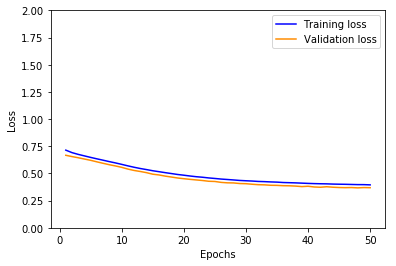

In [7]:
#get the data from the training
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
acc_values = history_dict['acc']
val_acc_values = history_dict['val_acc']
epochs = range(1, len(loss_values) + 1)

#plotting a figure for training loss
plt.figure()
plt.plot(epochs, loss_values, 'b', label='Training loss')
plt.plot(epochs, val_loss_values, 'darkorange', label='Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.ylim([0, 2])
plt.legend()
plt.show()

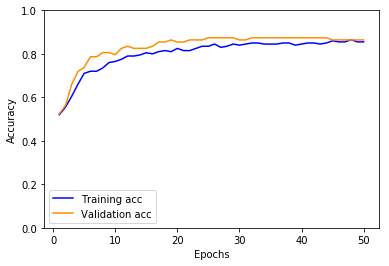

In [8]:
#plotting a figure for training accuracy
plt.figure()
plt.plot(epochs, acc_values, 'b', label='Training acc')
plt.plot(epochs, val_acc_values, 'darkorange', label='Validation acc')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend()
plt.show()

### Confusion matrix

Here we print the total accuracy and best guess accuracy. Confusion matrix on total accuracy seems to have gotten good amount of true positives and negatives.

In [11]:
# Print total accuracy and confusion matrix
valPredicts = model.predict(dataNorm)
y_pred = argmax(valPredicts, axis = 1)

# Best guess = Guess that all are normal
simpleGuess = zeros(len(y_pred))
cm0 = confusion_matrix(labels, simpleGuess)
true0 = np.trace(cm0)
N = len(labels)
acc0 = true0/N
print('Simple guess accuracy: {:.4f}'.format(acc0))
print('Confusion matrix:')
print(cm0)

#printing total accuracy
print(' ')
cm1 = confusion_matrix(labels, y_pred)
true1 = np.trace(cm1)
N = len(labels)
acc1 = true1/N
print('Total accuracy: {:.4f}'.format(acc1))
print('Confusion matrix:')
print(cm1)

Simple guess accuracy: 0.5413
Confusion matrix:
[[164   0]
 [139   0]]
 
Total accuracy: 0.8614
Confusion matrix:
[[152  12]
 [ 30 109]]


### Conclusion

While the execution of this exercise wasn't a full points performance from our part, a lot of learning was done and many things that seemed like hebrew a couple of weeks ago don't seem as complicated now. In that sense the aims of the assignment were met.